# Package Import and Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay, make_scorer
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

<div style="font-size:18px; line-height:1.4;">

# Index


    
1. [Business Understanding](#business-understanding)  
2. [Data Understanding](#data-understanding)  
3. [Data Preparation](#data-preparation)  
4. [Modeling](#modeling)  
5. [Evaluation](#evaluation)  
6. [Deployment](#deployment)
7. [Conclusions and Recommendations](#conclusions-and-recommendations) 
    
</div>

<a id="business-understanding"></a>
# I. Business Understanding 

### A. Business Objectives

The objective of this project is to support a Sales department for SaaS solutions of a company in improving the effectiveness and profitability of its sales strategies and marketing strategies by accurately predicting which type of product a customer is most likely to purchase. Historically, this B2B SaaS department havd relied on manual segmentation and intuition, which can lead to poorly targeted campaigns (**with a current conversion rate of ~10%**), high customer acquisition costs, and missed cross-selling opportunities. In this context, the focus is not on the profitability or margin of the sale, but rather on improving predictability to better align offerings with customer profiles

To address this, the business seeks to implement a data-driven product recommendation system that considers the client’s segment, industry, and seasonality. By doing so, the company aims to:

- Improve product alignment with client needs
- Increase campaign conversion rates (today are at ~10% in the )
- Reduce wasted efforts in sales and marketing
- Launch the right products to the right clients at the right time to **maximize the income**

Success will be measured by improvements in conversion rate, average revenue per customer, and marketing cost efficiency compared to historical benchmarks.

---

### B. Required Data

This project will use the **Amazon AWS SaaS Sales Dataset**, which includes around 10,000 historical transaction records. 

This dataset was chosen due to the challenges of accessing real data from a direct source, as data protection laws and the company's strict information security policies limit its availability. The data originally envisioned for the project is highly similar to the Amazon AWS SaaS Sales Dataset, making it a suitable alternative for research purposes and the development of the predictive model.

The dataset contains the following fields:

- **Order Date**: capturing seasonality and purchase timing  
- **Industry and Segment**: defining the client type  
- **Country and Region**: indicating geographic factors  
- **Product**: target variable to predict  
- **Other fields**: including sales, discount, and profit, to enrich the customer context

This data will allow us to train machine learning models to predict the most probable product purchased by a given customer profile at a certain time of the year.

---

### C. Project Plan

This problem will be addressed as a **multi-class classification** task. Multiple supervised learning techniques will be tested to build the best product recommender model. These include:

- **Decision Trees and Random Forests**: for transparency and interpretability
- **XGBoost**: for high-performance modeling
- **K-Nearest Neighbors**: as baseline model

The project will be executed using the CRISP-DM methodology and will involve steps such as data preparation, feature engineering, model selection and tuning, evaluation, and deployment planning.

The final deliverable is a system that can suggest the most likely product to offer a new or existing customer, based on their profile and season. This tool will enable better targeting of sales efforts, smarter product launch planning, and more effective marketing communication.


---

<a id="data-understanding"></a>
# II. Data Understanding

This dataset includes transactional records from a B2B SaaS company offering sales and marketing software to other businesses. Each row corresponds to a unique order, totaling 9,994 transactions. Several of the columns serve solely as identifiers for records, transactions, products, or customers, and do not contribute meaningfully to the analytical goal of this project.

## A. Column Description

| Columns Name | Column Description |
|--------------|--------------------|
| Row ID       | A unique identifier for each transaction. |
| Order ID     | A unique identifier for each order. |
| Order Date   | The date when the order was placed. |
| Date Key     | A numerical representation of the order date (YYYYMMDD). |
| Contact Name | The name of the person who placed the order. |
| Country      | The country where the order was placed. |
| City         | The city where the order was placed. |
| Region       | The region where the order was placed. |
| Subregion    | The subregion where the order was placed. |
| Customer     | The name of the company that placed the order. |
| Customer ID  | A unique identifier for each customer. |
| Industry     | The industry the customer belongs to. |
| Segment      | The customer segment (SMB, Strategic, Enterprise, etc.). |
| Product      | The product was ordered. |
| License      | The license key for the product |
| Sales        | The total sales amount for the transaction. |
| Quantity     | The total number of items in the transaction |
| Discount     | The discount applied to the transaction. |
| Profit       | The profit from the transaction. |

## B. Data OverView
- 9994/rows
- 19 columnas

The data contains no null or duplicate values, but there are a few mis-formatted columns, such as `Order Date` , which is stored as an object when it should be a datetime. 

Additionally, there are several identifier fields that, given the business objective, do not add value to the analysis (for example, `Quantity`, `Contact Name` or `Customer`).

In [2]:
# Loading original dataset
df = pd.read_csv("DATA/SaaS-Sales.csv")
df.head()

,Row ID,Order ID,Order Date,Date Key,Contact Name,Country,City,Region,Subregion,Customer,Customer ID,Industry,Segment,Product,License,Sales,Quantity,Discount,Profit
0,1,EMEA-2022-152156,11/9/2022,20221109,Nathan Bell,Ireland,Dublin,EMEA,UKIR,Chevron,1017,Energy,SMB,Marketing Suite,16GRM07R1K,261.9600,2,0.00,41.9136
1,2,EMEA-2022-152156,11/9/2022,20221109,Nathan Bell,Ireland,Dublin,EMEA,UKIR,Chevron,1017,Energy,SMB,FinanceHub,QLIW57KZUV,731.9400,3,0.00,219.5820
2,3,AMER-2022-138688,6/13/2022,20220613,Deirdre Bailey,United States,New York City,AMER,NAMER,Phillips 66,1056,Energy,Strategic,FinanceHub,JI6BVL70HQ,14.6200,2,0.00,6.8714
3,4,EMEA-2021-108966,10/11/2021,20211011,Zoe Hodges,Germany,Stuttgart,EMEA,EU-WEST,Royal Dutch Shell,1031,Energy,SMB,ContactMatcher,DE9GJKGD44,957.5775,5,0.45,-383.0310
4,5,EMEA-2021-108966,10/11/2021,20211011,Zoe Hodges,Germany,Stuttgart,EMEA,EU-WEST,Royal Dutch Shell,1031,Energy,SMB,Marketing Suite - Gold,OIF7NY23WD,22.3680,2,0.20,2.5164


In [3]:
# There are no null values
df.isnull().sum().sum()

0

In [4]:
# There are no duplicates
df[df.duplicated(keep=False)]

,Row ID,Order ID,Order Date,Date Key,Contact Name,Country,City,Region,Subregion,Customer,Customer ID,Industry,Segment,Product,License,Sales,Quantity,Discount,Profit


In [5]:
# There are no negative sales values representing credit notes that are not useful for the analysis
df[df['Sales'] < 0]

,Row ID,Order ID,Order Date,Date Key,Contact Name,Country,City,Region,Subregion,Customer,Customer ID,Industry,Segment,Product,License,Sales,Quantity,Discount,Profit


## C. Exploring data

In [6]:
df.describe()

,Row ID,Date Key,Customer ID,Sales,Quantity,Discount,Profit
count,9994.000000,9.994000e+03,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,2.021803e+07,1049.771963,229.858001,3.789574,0.156203,28.656896
std,2885.163629,1.123898e+04,29.719388,623.245101,2.225110,0.206452,234.260108
min,1.000000,2.020010e+07,1001.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,2.021052e+07,1024.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,2.022063e+07,1049.000000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,2.023052e+07,1076.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,2.023123e+07,1101.000000,22638.480000,14.000000,0.800000,8399.976000


In [7]:
df.info() ##Order Date are not in datetime Dtaype

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Row ID        9994 non-null   int64  
 1   Order ID      9994 non-null   object 
 2   Order Date    9994 non-null   object 
 3   Date Key      9994 non-null   int64  
 4   Contact Name  9994 non-null   object 
 5   Country       9994 non-null   object 
 6   City          9994 non-null   object 
 7   Region        9994 non-null   object 
 8   Subregion     9994 non-null   object 
 9   Customer      9994 non-null   object 
 10  Customer ID   9994 non-null   int64  
 11  Industry      9994 non-null   object 
 12  Segment       9994 non-null   object 
 13  Product       9994 non-null   object 
 14  License       9994 non-null   object 
 15  Sales         9994 non-null   float64
 16  Quantity      9994 non-null   int64  
 17  Discount      9994 non-null   float64
 18  Profit        9994 non-null 

### C.1. Data Distribution 

There is a skewed distribution in the numerical fields:

- **Sales**: Displays outliers.
- **Discount**: 86% of the values are concentrated between 0% and 20%.

Additionally, there are fields with too many categories that could introduce high variability into the model and are not conceptually relevant to the analysis based on the stated objective:

- **Country**: Contains many unique categories.
- **City**: Contains many unique categories.
- **Region**: Not relevant to the analysis.
- **Subregion**: Has too many categories and is not aligned with the business objective.


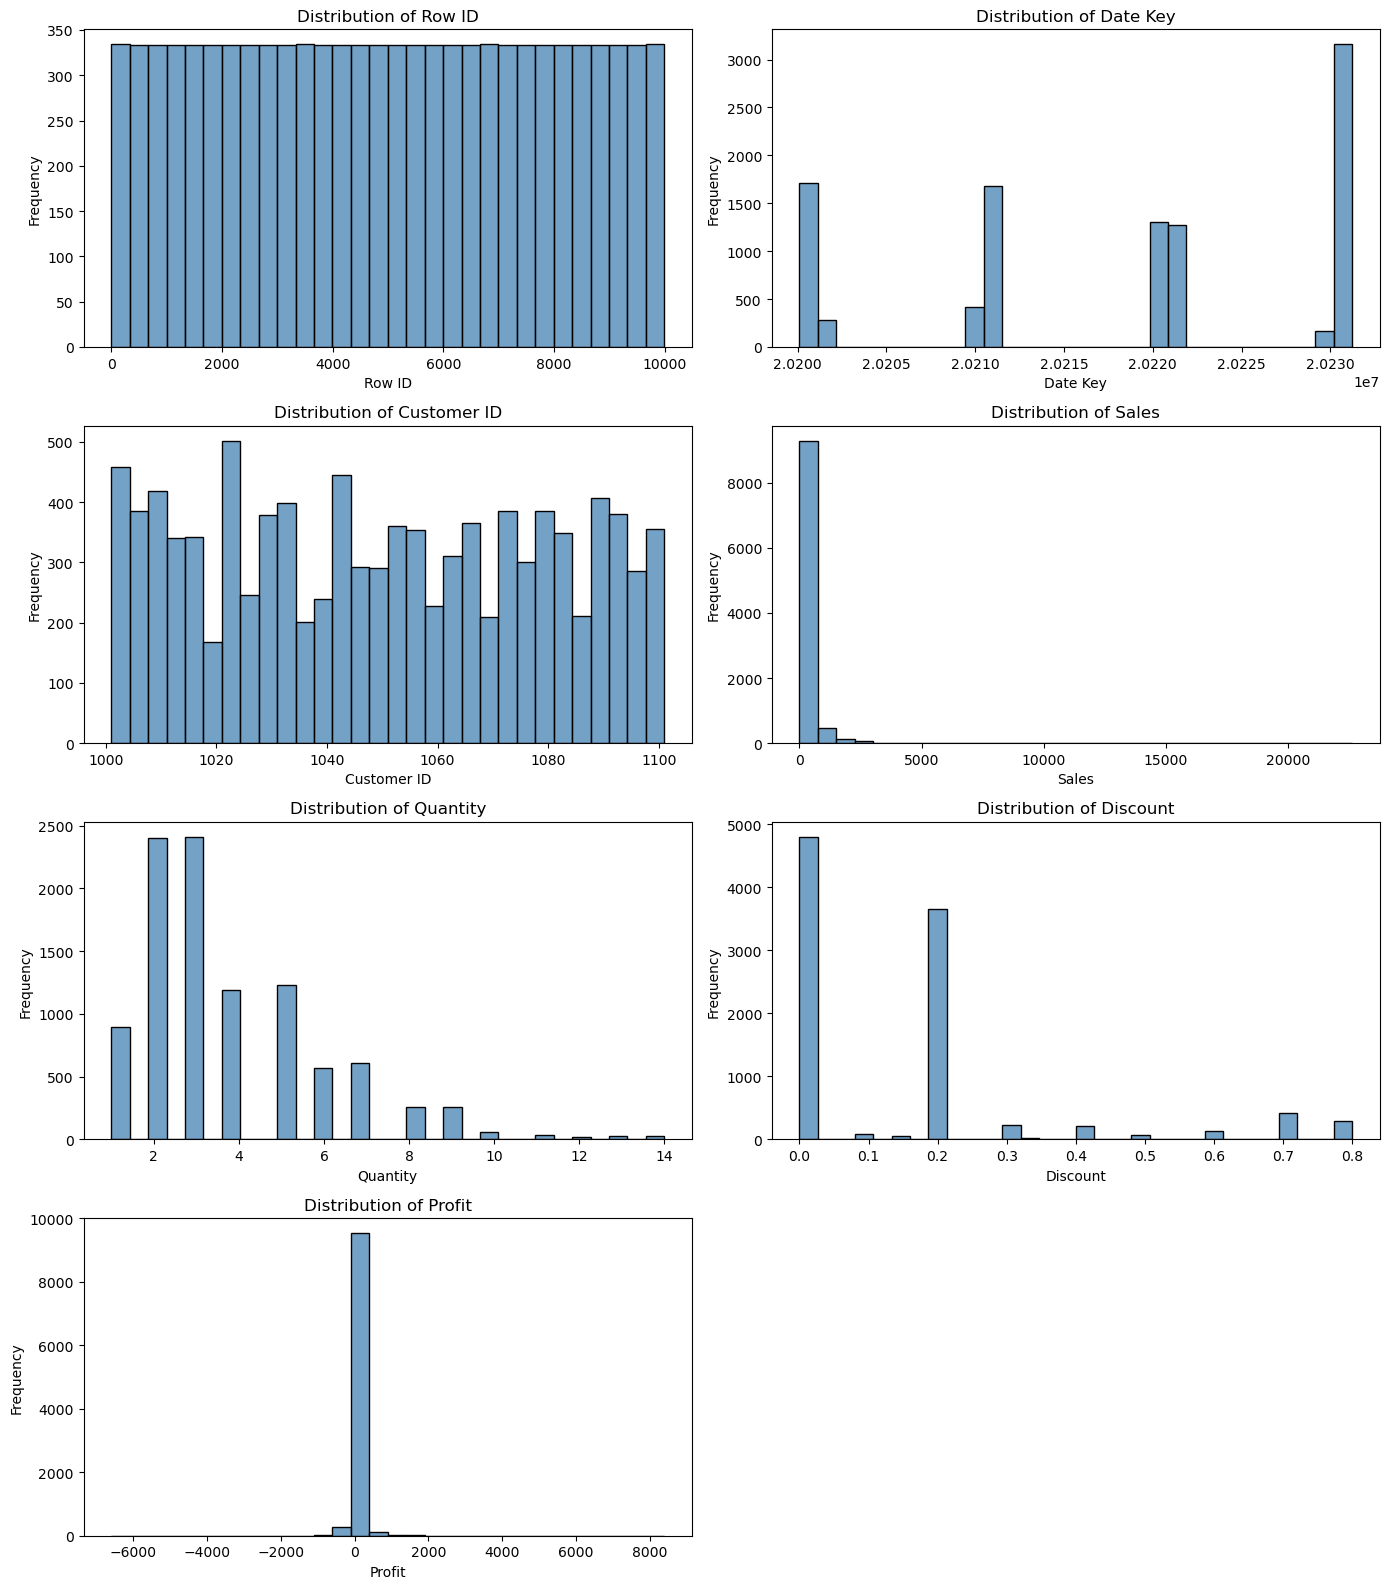

In [8]:
# Identify real numeric columns from the dataset
numeric_cols = df.select_dtypes(include='number').columns.tolist()

# Ajustar número de subplots basado en cantidad de columnas numéricas
n_cols = 2
n_rows = (len(numeric_cols) + 1) // n_cols

# Fig
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, n_rows * 4))
axes = axes.flatten()

# Plot
for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], bins=30, color='steelblue', ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

for j in range(len(numeric_cols), len(axes)):
    axes[j].set_visible(False)
    
plt.tight_layout()
plt.show()

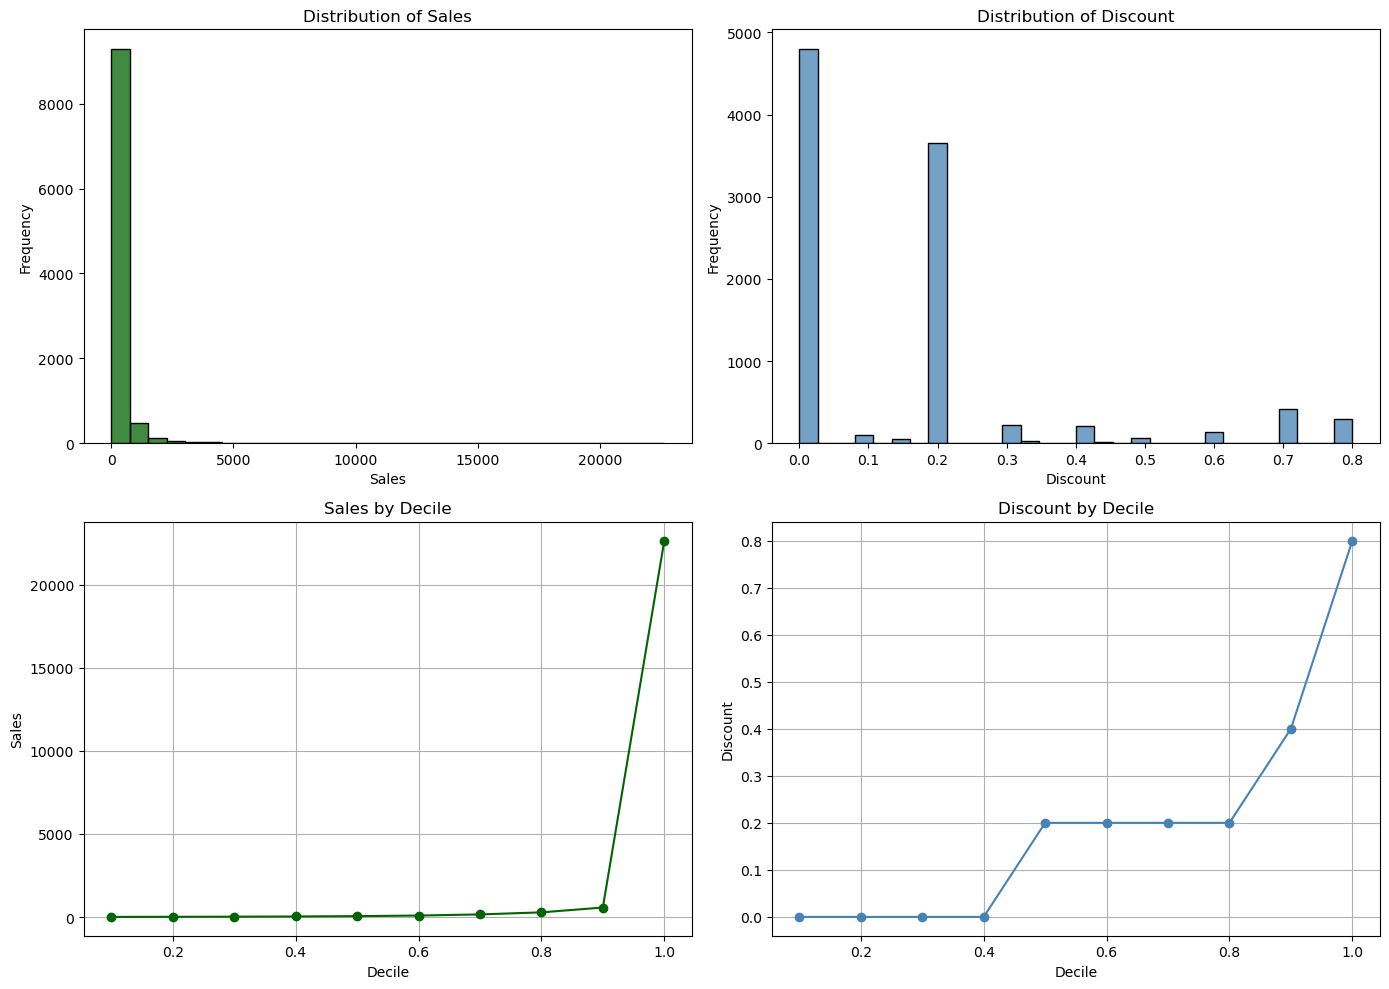

In [9]:
################## Relevant Numerical Variables ##################
# Columns and quantiles
num_cols = ['Sales', 'Discount']
q = np.arange(0.1, 1.1, 0.1)
dec = {col: df[col].quantile(q) for col in num_cols}

# Fig format
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
colors = ['darkgreen', 'steelblue']

# Histograms
for i, col in enumerate(num_cols):
    sns.histplot(df[col], ax=axes[0, i], bins=30, color=colors[i])
    axes[0, i].set(title=f'Distribution of {col}', xlabel=col, ylabel='Frequency')

# Decile plots
for i, col in enumerate(num_cols):
    axes[1, i].plot(q, dec[col], marker='o', color=colors[i])
    axes[1, i].set(title=f'{col} by Decile', xlabel='Decile', ylabel=col)
    axes[1, i].grid(True)

plt.tight_layout()
plt.show()

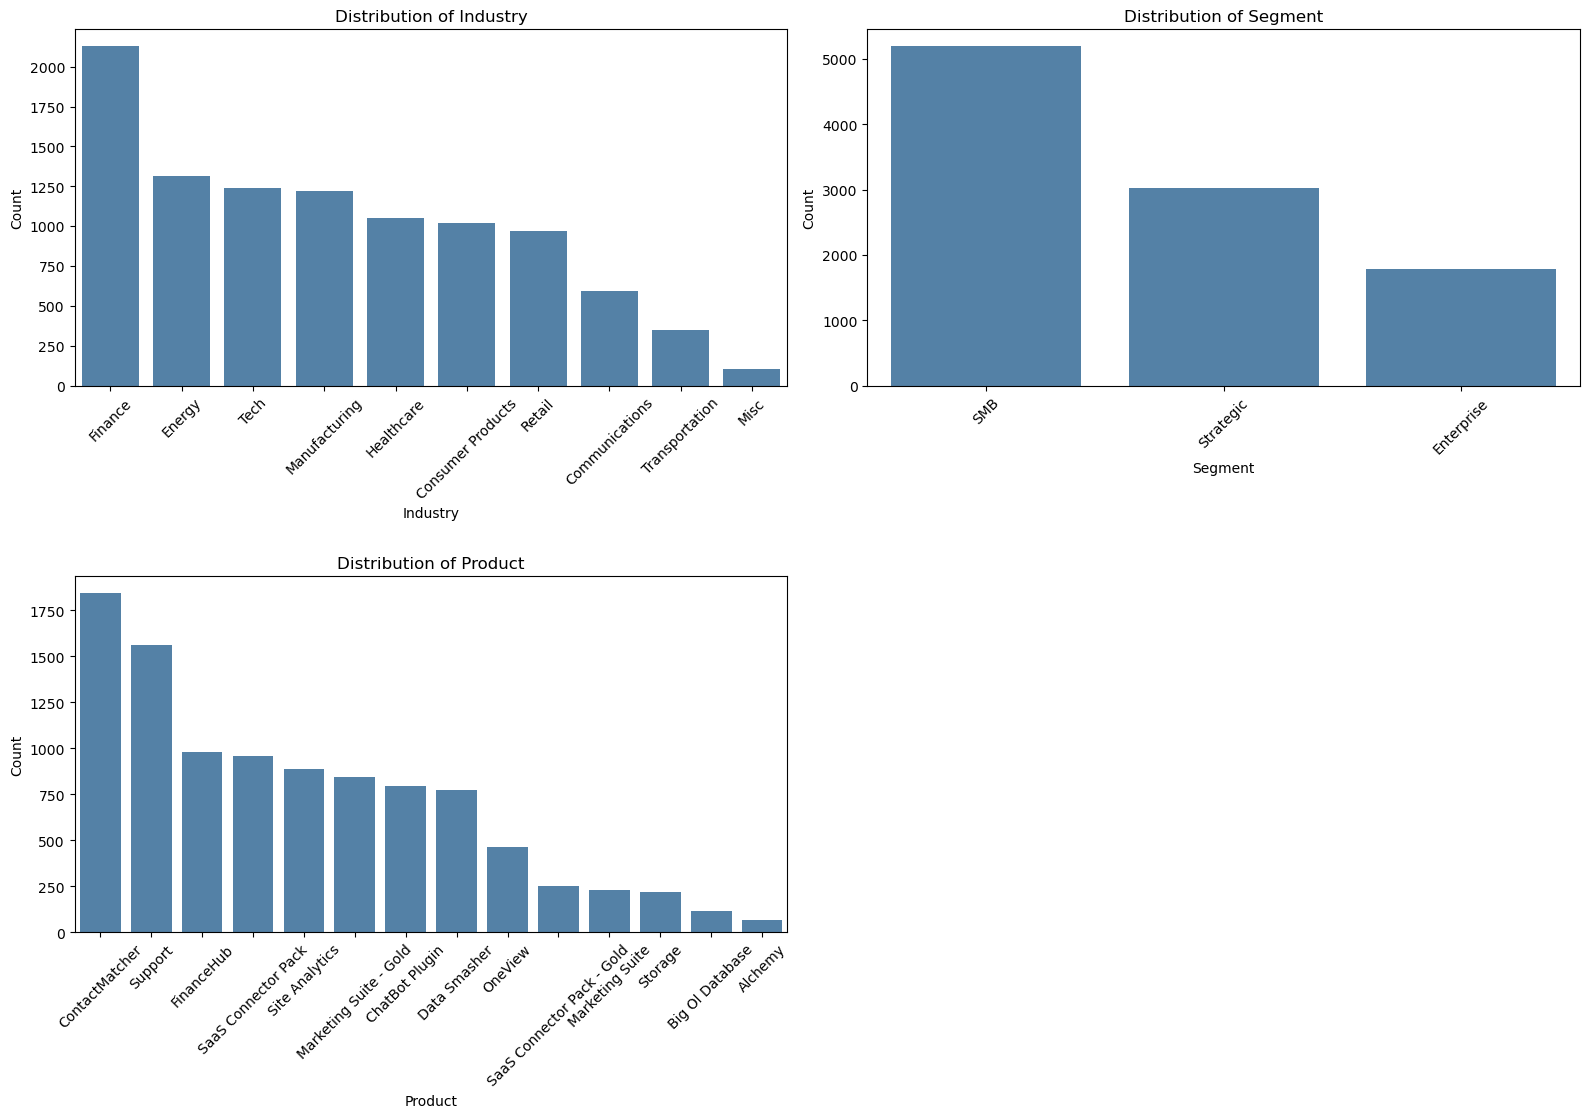

In [10]:
################## Relevant Categorical Variables ##################
# Columns
cat_cols = ['Industry', 'Segment', 'Product']

# Fig format
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 15))
axes = axes.flatten()

# Histograms
for i, col in enumerate(cat_cols):
    order = df[col].value_counts().index
    sns.countplot(data=df, x=col, order=order, color='steelblue', ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

# Hide empty subplots
if len(cat_cols) < len(axes):
    for j in range(len(cat_cols), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


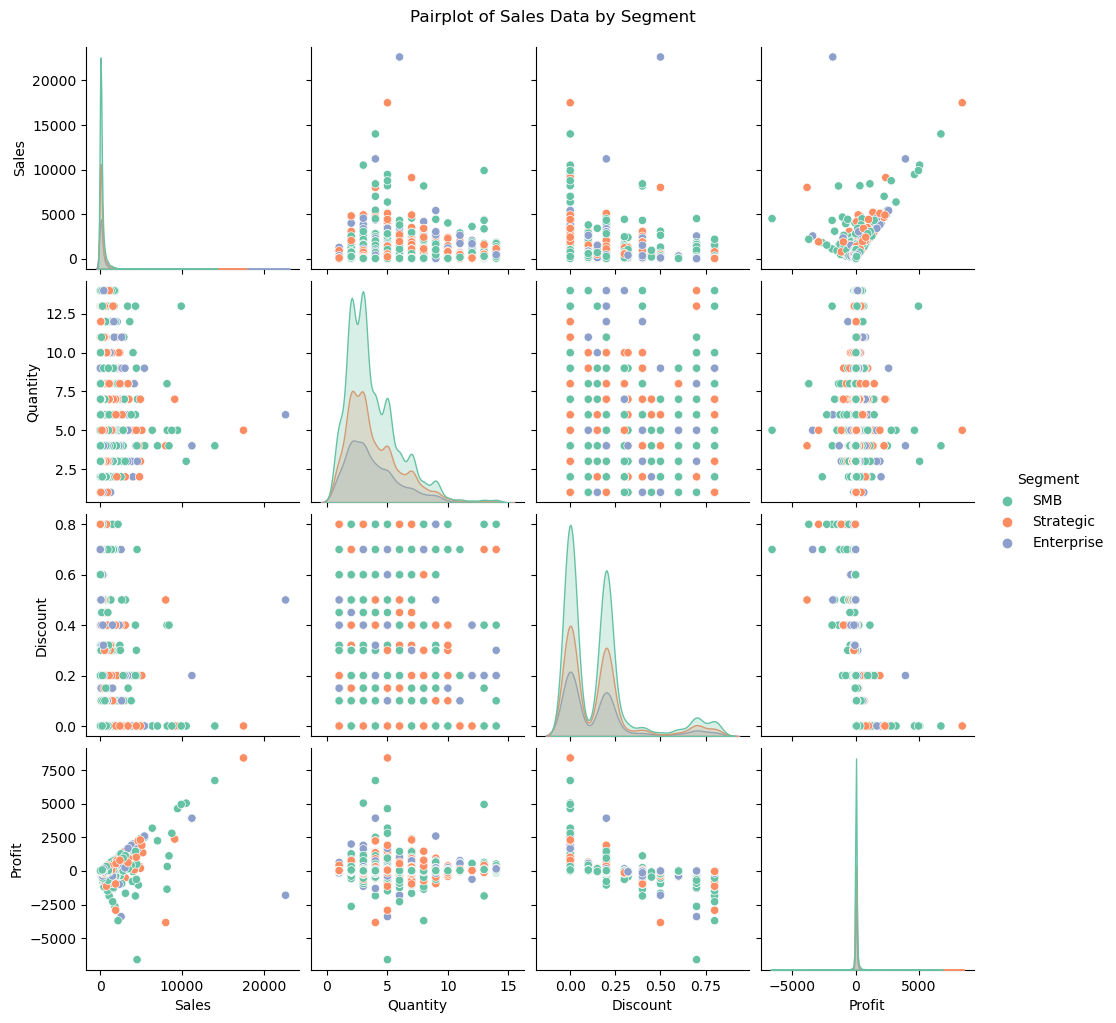

In [11]:
cols = ['Sales', 'Quantity', 'Discount', 'Profit']
df_sample = df[cols + ['Segment']].dropna()

# Pairplot
sns.pairplot(df_sample, hue='Segment', diag_kind='kde', palette='Set2')
plt.suptitle('Pairplot of Sales Data by Segment', y=1.02)
plt.show()


### C.2. Bivariate Analysis

By performing a bivariate analysis of the relevant data, we find that:

- The majority of sales are concentrated in the **SMB segment**, accounting for **50.6%**.
- The industries with the highest purchase volumes are **Finance**, **Energy**, and **Manufacturing**.

There is a relationship between the **amount sold** and the company's **segment** and **industry**.


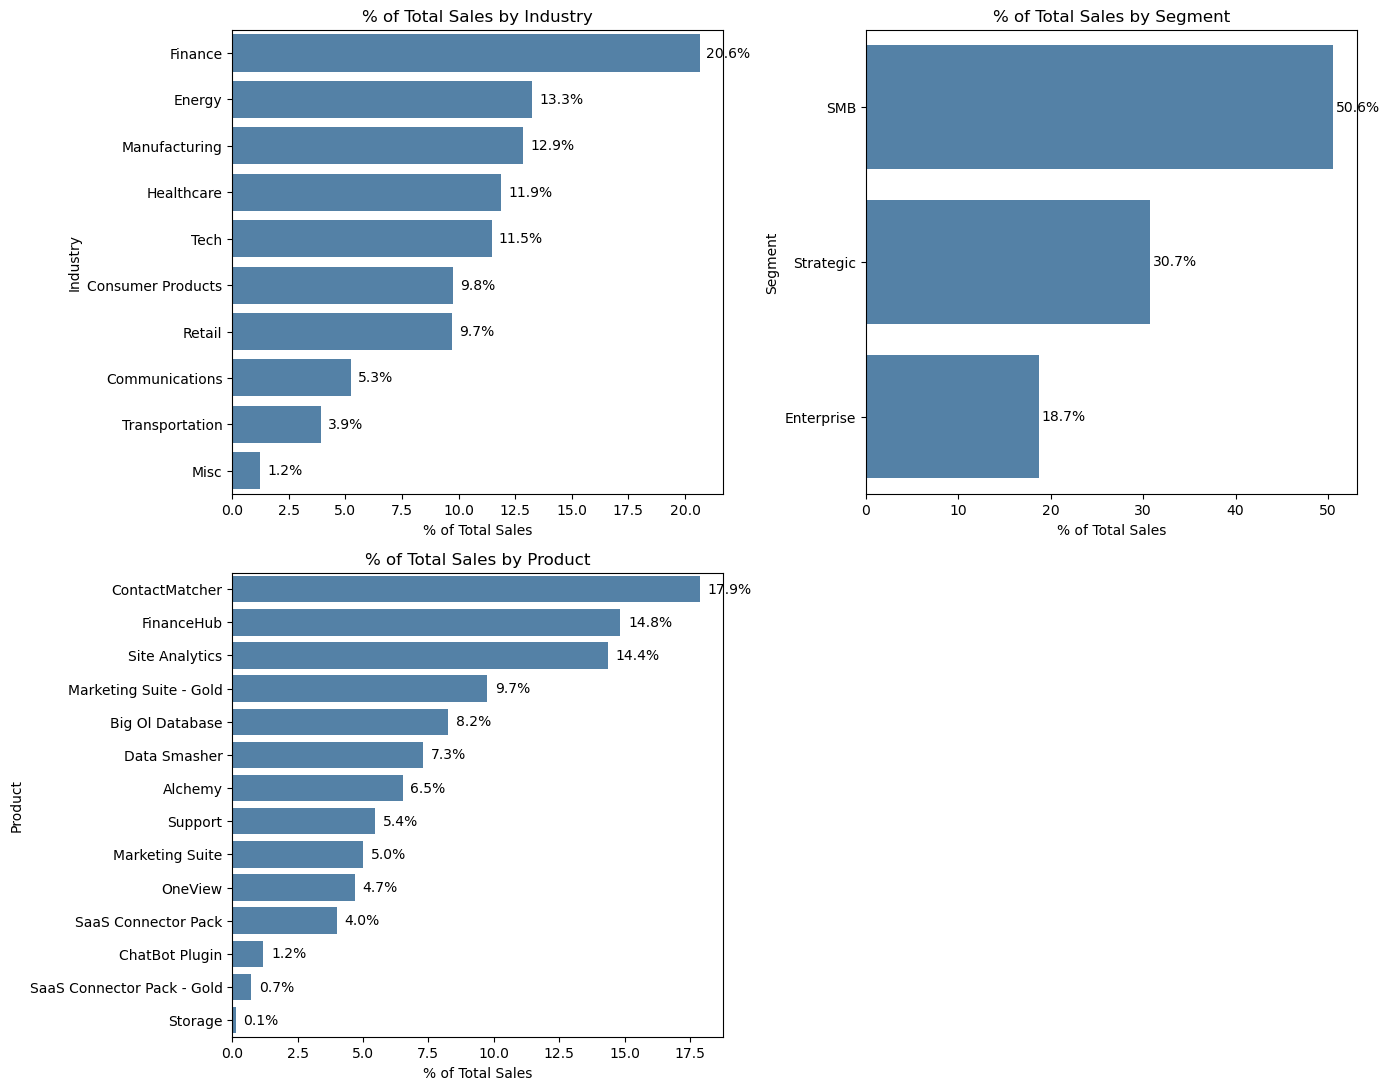

In [13]:
################## Sales Contribution (%) by relevant category variable ##################
# Define relevant categorical columns
total_sales = df['Sales'].sum()

# Fig format
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 16))
axes = axes.flatten()

# Histograms
for i, col in enumerate(cat_cols):
    pct = df.groupby(col)['Sales'].sum().sort_values(ascending=False) / total_sales * 100
    sns.barplot(x=pct.values, y=pct.index, ax=axes[i], color='steelblue')
    axes[i].set_title(f'% of Total Sales by {col}')
    axes[i].set_xlabel('% of Total Sales')
    axes[i].set_ylabel(col)
    for j, val in enumerate(pct.values):
        axes[i].text(val + 0.3, j, f'{val:.1f}%', va='center', fontsize=10)

# Hide unused axes
for ax in axes[len(cat_cols):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

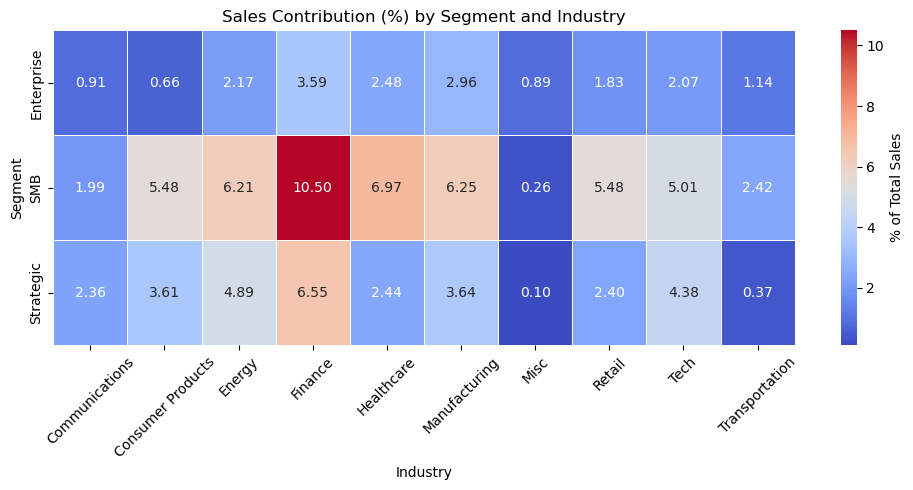

In [14]:
################## Sales Contribution (%) by Segment and Industry ##################
# Pivot table
sales_pivot = df.pivot_table(index='Segment',columns='Industry', values='Sales',aggfunc='sum',fill_value=0)

# Convert to percentages
total_sales = sales_pivot.values.sum()
sales_pct = (sales_pivot / total_sales * 100).round(2)

# Plot heatmap with % values
plt.figure(figsize=(10, 5))
sns.heatmap(sales_pct, annot=True, fmt='.2f', cmap='coolwarm', linewidths=.5, cbar_kws={'label': '% of Total Sales'})
plt.title('Sales Contribution (%) by Segment and Industry')
plt.xlabel('Industry')
plt.ylabel('Segment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [15]:
############ TOP 5 sales by Segment and Industry #######################
# Group by Segment and Industry
grouped1 = ( df.groupby(['Segment', 'Industry'])['Sales'].sum().reset_index().sort_values('Sales', ascending=False))

# Calculate percentage and cumulative percentage
total_sales = grouped1['Sales'].sum()
grouped1['% of Total'] = grouped1['Sales'] / total_sales * 100
grouped1['Cumulative %'] = grouped1['% of Total'].cumsum()

grouped1.head(5).style.hide(axis=0)

Segment,Industry,Sales,% of Total,Cumulative %
SMB,Finance,241120.291400,10.496265,10.496265
SMB,Healthcare,160185.326200,6.973066,17.469331
Strategic,Finance,150572.652400,6.554614,24.023945
SMB,Manufacturing,143552.513400,6.249019,30.272964
SMB,Energy,142548.299600,6.205304,36.478268


In [16]:
############ TOP 5 sales by Industry #######################
# Group by Segment, Industry, and Product to sum Sales
grouped2 = (
    df.groupby(['Industry'])['Sales']
    .sum()
    .reset_index()
    .sort_values('Sales', ascending=False)
)
# Calculate percentage and cumulative percentage
total_sales2 = grouped2['Sales'].sum()
grouped2['% of Total'] = grouped2['Sales'] / total_sales * 100
grouped2['Cumulative %'] = grouped2['% of Total'].cumsum()

grouped2.head(5).style.hide(axis=0)

Industry,Sales,% of Total,Cumulative %
Finance,474150.484400,20.640358,20.640358
Energy,304644.140900,13.261537,33.901895
Manufacturing,295192.381200,12.850090,46.751985
Healthcare,273183.288200,11.892007,58.643992
Tech,263169.027700,11.456074,70.100066


In [17]:
############ TOP 5 sales by Product #######################
# Group by Segment, Industry, and Product to sum Sales
grouped3 = (
    df.groupby(['Product'])['Sales']
    .sum()
    .reset_index()
    .sort_values('Sales', ascending=False)
)
# Calculate percentage and cumulative percentage
total_sales3 = grouped3['Sales'].sum()
grouped3['% of Total'] = grouped3['Sales'] / total_sales * 100
grouped3['Cumulative %'] = grouped3['% of Total'].cumsum()

grouped3.head(5).style.hide(axis=0)

Product,Sales,% of Total,Cumulative %
ContactMatcher,410378.265000,17.864274,17.864274
FinanceHub,340935.415000,14.841341,32.705615
Site Analytics,330007.054000,14.365616,47.071231
Marketing Suite - Gold,223843.608000,9.744190,56.815421
Big Ol Database,189238.631000,8.237792,65.053213


### C.3. Seasonality and Time Series

It can be observed that sales exhibit yearly seasonality, and when grouped by company segment, the top three product and industry sales are evident, as shown in the charts.

In [18]:
# Datetime format
df['Order Date'] = pd.to_datetime(df['Order Date']) # Otherwise it is not possible to work with the time series.

C:\Users\pcist\AppData\Local\Temp\ipykernel_32832\3777002400.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


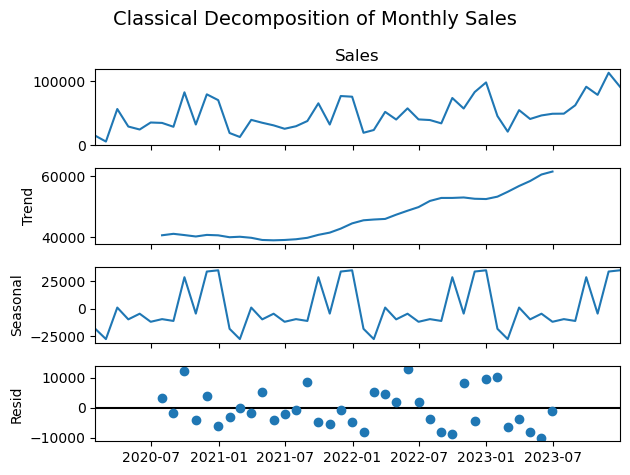

In [19]:
############ Sales Time Series #######################
df_ts = df[['Order Date', 'Sales']]
df_ts.set_index('Order Date', inplace=True)
df_ts.index = pd.to_datetime(df_ts.index)
df_ts_monthly = df_ts.resample('M').sum()

# Classical decomposition (assuming yearly seasonality ~12 month)
decomp = seasonal_decompose(df_ts_monthly['Sales'], model='additive', period=12)

# Plot
decomp.plot()
plt.suptitle('Classical Decomposition of Monthly Sales', fontsize=14)
plt.tight_layout()
plt.show()


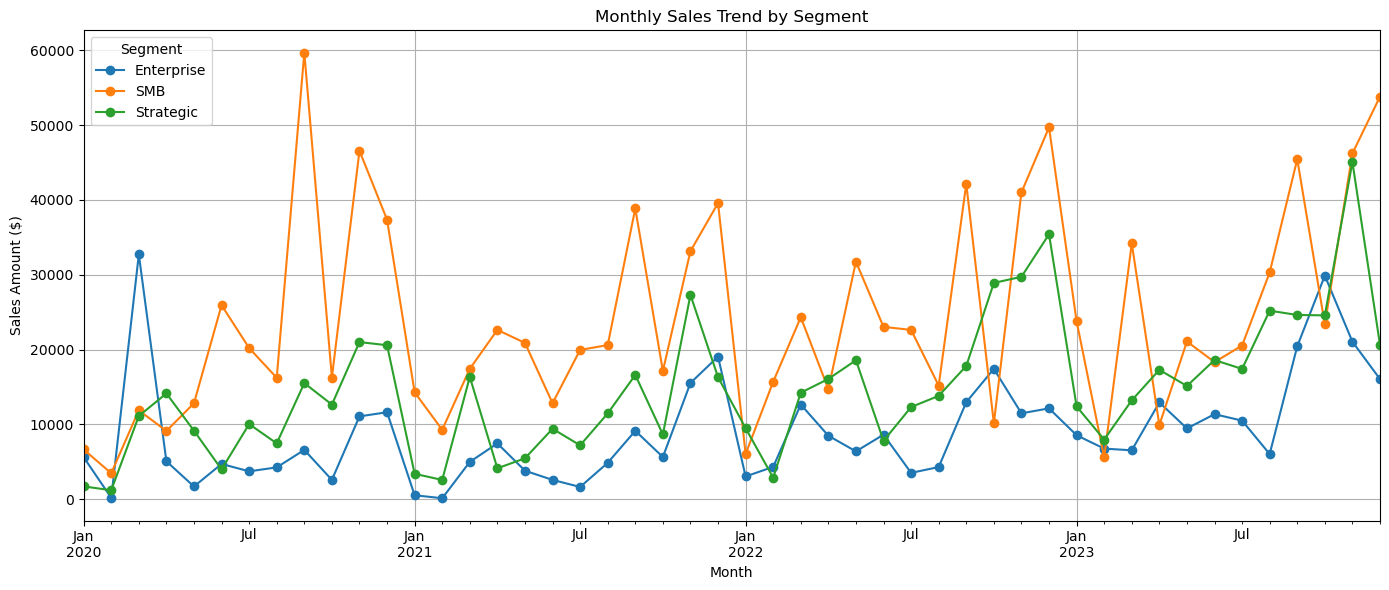

In [20]:
############ Segment Time Series #######################
# Time Series resample by month and segment, summing sales
monthly_segment_sales = (df.groupby([pd.Grouper(key='Order Date', freq='M'), 'Segment'])['Sales'].sum().reset_index())
pivot_seg = monthly_segment_sales.pivot(index='Order Date', columns='Segment', values='Sales') # Pivot for plotting

# Plot
pivot_seg.plot(figsize=(14, 6), marker='o')
plt.title('Monthly Sales Trend by Segment')
plt.xlabel('Month')
plt.ylabel('Sales Amount ($)')
plt.grid(True)
plt.legend(title='Segment')
plt.tight_layout()
plt.show()

## D. Summary of findings

### D.1. Data Quality
The dataset contains 9,994 rows with no null values or duplicated entries. All transactions are valid, and no negative sales were detected, indicating no presence of credit notes or data quality issues.

### D.2. Numerical Variable Distribution
The distribution of `Sales` is highly skewed due to outliers, with 90% of values below 3000, while a few exceed 20000. The `Discount` field is concentrated between 0% and 20% in 86% of transactions, suggesting moderate and selective discounting strategies.

### D.3. Categorical Fields and Dimensionality Reduction
Fields such as `Country`, `City`, `Region`, and `Subregion` show high cardinality and limited business value for this analysis. They are excluded or considered for aggregation to reduce noise. Key predictors will be `Industry`, `Segment`, and `License`.

### D.4. Key Category Insights
- **Industry**: Most sales are concentrated in Finance, Energy, and Manufacturing industries.
- **Segment**: The SMB segment alone accounts for over 50% of all transactions.
- **Product**: A few product types dominate, showing potential for focused targeting (top 6 has 79,9% of total Sales).

### D.5. Segment-Industry Interaction
The heatmap of sales contribution (%) reveals that the combination of `SMB` and `Finance` represents over 10% of total sales, with other important pairs including `SMB + Healthcare` and `Strategic + Finance`.

### D.6. Time Series and Seasonality
The time series analysis confirms both a yearly seasonality and an upward trend in overall sales. Decomposition of the monthly sales indicates a predictable cyclic pattern. This validates the inclusion of temporal features (month, quarter) in the predictive model.

These findings guide the feature selection and modeling strategy for the classification task ahead.


---

<a id="data-preparation"></a>
# III. Data Preparation

In this phase, the dataset was cleaned and transformed to prepare it for machine learning modeling. The goal was to enable the prediction of which product a customer is most likely to purchase, based on their segment, industry, and the time of year.

In [21]:
# Creating a copy of the original DF
df_c = df.copy()

In [22]:
# Format datetime
df_c['Order Date'] = pd.to_datetime(df['Order Date']) # Otherwise it is not possible to work with the time series.

## A. Variable Selection and Cleaning

A copy of the original dataset was created, and several columns were removed due to low predictive value or potential noise. These included:

- Identifier fields (`Row ID`, `Order ID`, `Customer ID`)
- Personal or detailed location data (`Contact Name`, `City`, `Country`, etc.)
- Financial columns not aligned with the business goal (`Profit`, `Discount`, `Quantity`)

Outliers in the sales variable were addressed by keeping only the bottom 90% of values. This reduced the impact of extreme sales figures that could distort the model.

Additionally, a new variable, `Regular Sale`, was created to reflect the gross sales value before discounts, which helps better represent customer intent.

In [23]:
# Calculate sale value without discount
df_c['Regular Sale'] = np.where(df['Discount'] < 1.0, df['Sales'] / (1 - df['Discount']), df['Sales'])

In [24]:
# Filter to retain only the bottom 90% of sales (remove outliers)
df_c = df_c[df_c['Sales'] <= df_c['Sales'].quantile(0.90)]

In [25]:
# Drop columns not useful or problematic for modeling
df_c.drop(columns=['Row ID', 'Order ID', 'Date Key', 'Contact Name', 'Customer', 'Customer ID', 'License'], inplace=True)
df_c.drop(columns=['City', 'Country', 'Region','Subregion'], inplace=True)
df_c.drop(columns=['Quantity', 'Discount', 'Profit'], inplace=True)
df_c.drop(columns=['Product', 'Industry', 'Sales'], inplace=True)  # Columns replaced below

## B. Creating Time Features

To include seasonality in the model, two new time-based features were extracted from the order date:

- `Month`: capturing monthly purchase patterns.
- `Quarter`: capturing broader seasonal trends across the year.

After creating these variables, the original `Order Date` column was dropped.

In [26]:
# # Extract time-related features
df_c['Month'] = df_c['Order Date'].dt.month
df_c['Quarter'] = df_c['Order Date'].dt.quarter

df_c.drop(columns=['Order Date'], inplace=True)

## C. Grouping Categories

To simplify the data and improve model learning, two categorical variables were reclassified:

- **Product** categories were grouped into:
  - `Client Intelligence`
  - `Data & Analytics`
  - `Marketing & Engagement`
  - `Data Integration`

- **Industry** categories were grouped into:
  - `Core Economic`
  - `Health & Consumer`
  - `Retail & Comms`
  - `Other`
  
 These groupings reduced dimensionality and focused the model on meaningful business distinctions.
 

In [27]:
# Reclassify Product into 4 new categories
df_c['Product Category'] = df['Product']
df_c['Product Category'].replace(['ContactMatcher', 'FinanceHub'], 'Client Intelligence', inplace=True)
df_c['Product Category'].replace(['Site Analytics', 'Data Smasher', 
                                  'Alchemy', 'Big Ol Database', 'Storage'], 'Data & Analytics', inplace=True)
df_c['Product Category'].replace(['Marketing Suite', 'Marketing Suite - Gold', 
                                  'Support'], 'Marketing & Engagement', inplace=True)
df_c['Product Category'].replace(['SaaS Connector Pack', 'SaaS Connector Pack - Gold', 
                                  'ChatBot Plugin', 'OneView'], 'Data Integration', inplace=True)

In [28]:
# Reclassify Industry into 4 new categories
df_c['Industry Category'] = df['Industry']
df_c['Industry Category'].replace(['Finance', 'Energy', 'Tech', 'Manufacturing'], 'Core Economic', inplace=True)
df_c['Industry Category'].replace(['Healthcare', 'Consumer Products'], 'Health & Consumer', inplace=True)
df_c['Industry Category'].replace(['Retail', 'Communications'], 'Retail & Comms', inplace=True)
df_c['Industry Category'].replace(['Transportation', 'Misc'], 'Other', inplace=True)

## D. Encoding Categorical Variables

Since machine learning models require numerical input, categorical (object-type) variables were encoded using `LabelEncoder`, which is suitable for Decision Tree, Random Forest and XGBoost.

In [29]:
df_label = df_c.copy()

obj_cols = df_label.select_dtypes(include='object').columns
le = LabelEncoder()
for col in obj_cols:
    df_label[col] = le.fit_transform(df_label[col])

 ---

## 5. Final Dataset for Modeling

The data was split into:

- **Features (X)**: input variables used for prediction.
- **Target (y)**: the product category to be predicted.

A stratified 80/20 train-test split was applied to ensure balanced class distributions in both sets.


In [30]:
X = df_label.drop(columns=['Product Category'])
y = df_label['Product Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

---


## Summary

The dataset was cleaned by removing unnecessary data, adding time and sales features, grouping categories, and encoding variables. This prepared it for reliable classification models while keeping it easy to understand for business decisions.

<a id="modeling"></a>
# IV. Modeling

In this phase, different machine learning models were trained to predict the product category most likely to be purchased by a customer, based on variables such as industry, segment, and seasonality (month and quarter).

## A. Modeling Objective

The business objective was to increase the conversion rate of SaaS campaigns by identifying the product most likely to be purchased, depending on the customer's characteristics. As such, **classification models** were used to predict the product category from historical sales data.


## B. Model Selection

Several models were selected based on their ability to handle multi-class classification, interpretability, and performance:

- **Decision Tree Classifier**: For simplicity and interpretability.
- **Random Forest Classifier**: To improve generalization over decision trees.
- **XGBoost Classifier**: For advanced performance and better handling of data irregularities.
- **K-Nearest Neighbors (KNN)**: As a baseline model.

Support Vector Machines and Logistic Regression were discarded due to their poor performance in earlier tests.

In [31]:
# Models dictionary
models = {
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

## C. Pipelines and Preprocessing

Pipelines were used to standardize model preparation and ensure appropriate preprocessing:

- **StandardScaler** was used where necessary (e.g., for KNN).
- Tree-based models (Decision Tree, Random Forest, XGBoost) were used without scaling, as they are not sensitive to feature magnitudes.

In [32]:
####### Model and Evaluate formula
def evaluate_model_optimized(name, model, param_grid, X_train, X_test, y_train, y_test):
    print(f"\n Tuning model: {name}")
    
    # Pipeline for each model
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    # Paramgrid search
    grid = GridSearchCV(pipe, {'model__' + k: v for k, v in param_grid.items()}, 
                        scoring='accuracy', cv=5, n_jobs=-1, verbose=0)
    
    # Fit and preds
    start_time = time.time() #timestamp
    grid.fit(X_train, y_train) 
    elapsed = time.time() - start_time #timestamp
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    
    # Scoring
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"Best parameters: {grid.best_params_}")
    print(f"Training Time: {elapsed:.2f} seconds")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix plot
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
    disp.ax_.set_title(f"{name} - Confusion Matrix")
    plt.tight_layout()
    plt.show()

In [33]:
param_grids = {
            "KNN": {
                "n_neighbors": list(range(1, 31, 2)),
                "weights": ['uniform', 'distance']
            },
            "Decision Tree": {
                "max_depth": list(range(1, 31, 2)),
                "min_samples_split": [2, 5, 10]
            },
            "Random Forest": {
                "n_estimators": list(range(51, 81, 2)),
                "max_depth": list(range(1, 31, 2))
            },
            "XGBoost": {
                "n_estimators": list(range(51, 81, 2)),
                "max_depth": list(range(1, 31, 2))
            }
        }



 Tuning model: KNN
Best parameters: {'model__n_neighbors': 27, 'model__weights': 'distance'}
Training Time: 3.59 seconds
Accuracy: 0.2957
F1 Score (weighted): 0.2957
Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.28      0.29       485
           1       0.32      0.28      0.30       342
           2       0.30      0.32      0.31       481
           3       0.28      0.30      0.29       491

    accuracy                           0.30      1799
   macro avg       0.30      0.29      0.30      1799
weighted avg       0.30      0.30      0.30      1799



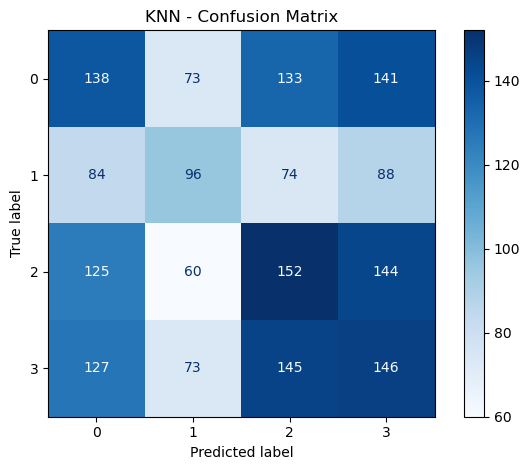


 Tuning model: Decision Tree
Best parameters: {'model__max_depth': 29, 'model__min_samples_split': 2}
Training Time: 0.43 seconds
Accuracy: 0.4786
F1 Score (weighted): 0.4787
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.49      0.48       485
           1       0.48      0.49      0.48       342
           2       0.46      0.47      0.46       481
           3       0.49      0.48      0.49       491

    accuracy                           0.48      1799
   macro avg       0.48      0.48      0.48      1799
weighted avg       0.48      0.48      0.48      1799



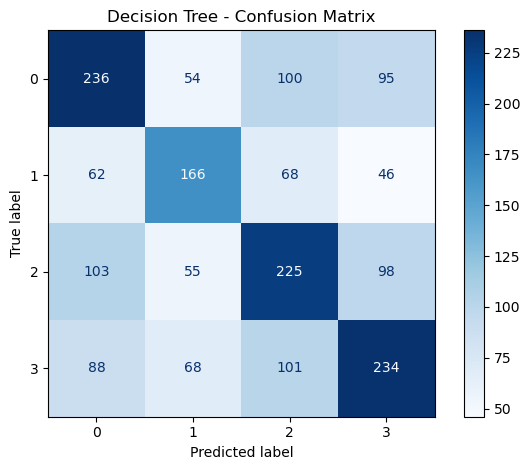


 Tuning model: Random Forest
Best parameters: {'model__max_depth': 7, 'model__n_estimators': 51}
Training Time: 31.80 seconds
Accuracy: 0.3191
F1 Score (weighted): 0.3130
Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.22      0.26       485
           1       0.35      0.24      0.29       342
           2       0.33      0.36      0.34       481
           3       0.30      0.44      0.36       491

    accuracy                           0.32      1799
   macro avg       0.32      0.31      0.31      1799
weighted avg       0.32      0.32      0.31      1799



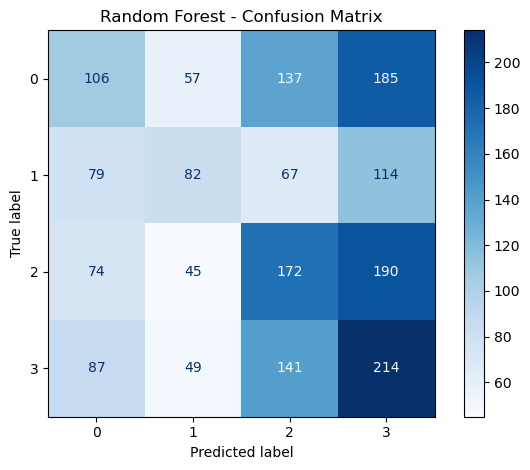


 Tuning model: XGBoost


C:\Users\pcist\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [12:58:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters: {'model__max_depth': 3, 'model__n_estimators': 73}
Training Time: 123.78 seconds
Accuracy: 0.3658
F1 Score (weighted): 0.3655
Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.33      0.34       485
           1       0.42      0.32      0.37       342
           2       0.34      0.43      0.38       481
           3       0.40      0.37      0.38       491

    accuracy                           0.37      1799
   macro avg       0.37      0.36      0.37      1799
weighted avg       0.37      0.37      0.37      1799



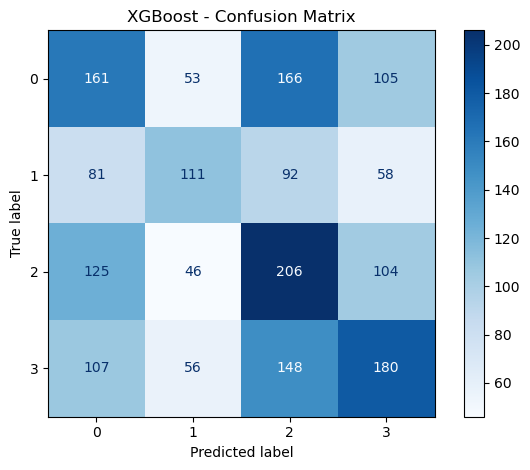

In [34]:
# Run evaluation
for name, model in models.items():
    evaluate_model_optimized(name, model, param_grids[name], X_train, X_test, y_train, y_test)


---

## D. Hyperparameter Tuning

A grid search with cross-validation was applied to find the best hyperparameters for each model. In particular:

- A wide range of values was tested, skipping every other number (e.g., `1, 3, 5...`) to ensure diversity in search space.
- Stratified 5-fold cross-validation was used to preserve class balance during validation.

Example for `Decision Tree`:

In [35]:
# Base Pipeline for Decision Tree
pipe_tree = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', DecisionTreeClassifier(random_state=42))
])

In [36]:
# Robust cross-validation
scores_acc = cross_val_score(pipe_tree, X_train, y_train, cv=5, scoring='accuracy')
scores_f1  = cross_val_score(pipe_tree, X_train, y_train, cv=5, scoring='f1_weighted')
print(f"CV Accuracy: {scores_acc.mean():.3f} ± {scores_acc.std():.3f}")
print(f"CV F1 (wtd):  {scores_f1.mean():.3f} ± {scores_f1.std():.3f}")

CV Accuracy: 0.454 ± 0.012
CV F1 (wtd):  0.454 ± 0.012


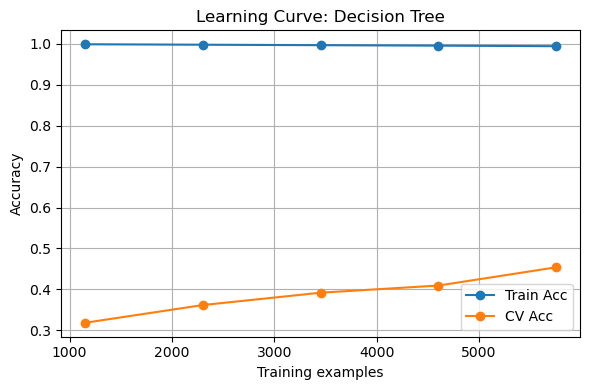

In [37]:
# Learning curve
train_sizes, train_scores, val_scores = learning_curve(
                                                    pipe_tree, X_train, y_train, cv=5,
                                                    train_sizes=np.linspace(0.2, 1.0, 5),
                                                    scoring='accuracy'
                                                    )
plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_scores.mean(1), 'o-', label='Train Acc')
plt.plot(train_sizes, val_scores.mean(1),   'o-', label='CV Acc')
plt.title("Learning Curve: Decision Tree")
plt.xlabel("Training examples"), plt.ylabel("Accuracy")
plt.legend(), plt.grid(True), plt.tight_layout()
plt.show()

In [38]:
# GridSearch for max_depth and min_samples_split
param_grid = {
    'clf__max_depth': [5,10,15,20,25], 
    'clf__min_samples_split': [2,5,10]
}
grid = GridSearchCV(pipe_tree, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)
best_tree = grid.best_estimator_
print("Best params:", grid.best_params_)

Best params: {'clf__max_depth': 25, 'clf__min_samples_split': 2}



## E. Model Evaluation

Each model was evaluated on the test set using classification accuracy and F1-score, focusing on their ability to correctly predict the product category across segments.

Key metrics were stored for comparison, and confusion matrices were visualized to understand model behavior across product categories.

## F. Best Model and Interpretability

The **Decision Tree** model performed best in balancing accuracy and interpretability. It correctly predicted product categories in a way that can be clearly explained to business users (e.g., segment → industry → quarter → product).

Random Forest and XGBoost models also provided strong performance but were treated more as black-box models with limited interpretability.



## Summary

Multiple models were evaluated with consistent preprocessing pipelines. The Decision Tree was selected as the most suitable model given its alignment with the business goal: actionable and understandable insights that help improve targeted marketing strategies.

---
<a id="evaluation"></a>
# V. Evaluation

This phase focused on comparing the trained models to determine which one best supported the business goal: identifying the most likely product category to be purchased by a customer, in order to improve campaign targeting and conversion rates.


## A. Evaluation Criteria

Models were evaluated based on:

- **Accuracy**: Overall percentage of correct predictions.
- **F1-Score (Macro)**: To balance performance across all product categories, especially considering class imbalance.
- **Interpretability**: Preference was given to models that offer transparent decision paths (essential for business users).
- **Confusion Matrix**: Used to analyze which product categories were better predicted and where models failed.

These metrics were chosen to ensure not just technical performance, but practical relevance in guiding marketing actions.

---

              precision    recall  f1-score   support

           0       0.48      0.48      0.48       485
           1       0.49      0.50      0.50       342
           2       0.45      0.46      0.45       481
           3       0.50      0.47      0.48       491

    accuracy                           0.48      1799
   macro avg       0.48      0.48      0.48      1799
weighted avg       0.48      0.48      0.48      1799



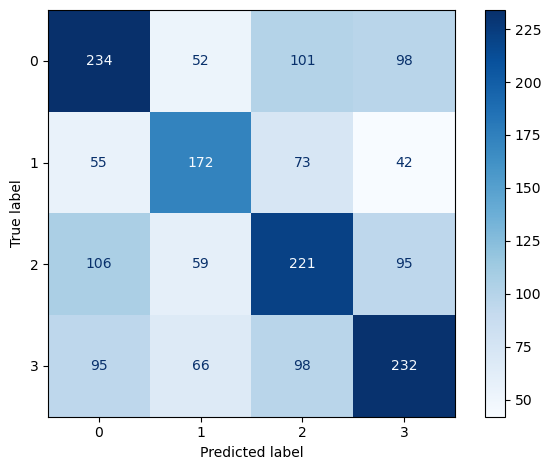

(None, None)

In [39]:
# Evaluate
y_pred = best_tree.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.tight_layout(), plt.show()

In [40]:
# Recall by class
report = classification_report(y_test, y_pred, output_dict=True)
recall = pd.DataFrame(report).loc['recall'][:4]
print("\nPer-class Recall:")
print(recall)


Per-class Recall:
0    0.482474
1    0.502924
2    0.459459
3    0.472505
Name: recall, dtype: float64


In [41]:
# Rule extraction (first 500 characters)
rules = export_text(best_tree.named_steps['clf'], feature_names=list(X.columns))
print("\nExtracted Rules:\n", rules[:500], "…")


Extracted Rules:
 |--- Regular Sale <= -0.21
|   |--- Regular Sale <= -0.66
|   |   |--- Regular Sale <= -0.70
|   |   |   |--- Regular Sale <= -0.73
|   |   |   |   |--- Industry Category <= 1.56
|   |   |   |   |   |--- Regular Sale <= -0.73
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- Regular Sale >  -0.73
|   |   |   |   |   |   |--- Segment <= -0.92
|   |   |   |   |   |   |   |--- Regular Sale <= -0.73
|   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |--- Regular S …


## B. Model Comparison

| Model          | Accuracy | F1-Score | Strengths                               | Weaknesses                       |
|----------------|----------|----------|------------------------------------------|----------------------------------|
| Decision Tree  | ~0.48    | ~0.48    | Transparent, interpretable, fast         | Slightly overfits at times       |
| Random Forest  | ~0.26    | ~0.26    | Handles variance, robust to noise        | Less interpretable               |
| XGBoost        | ~0.27    | ~0.27    | High performance, handles complexity     | Requires more computation        |
| KNN            | ~0.29    | ~0.28    | Easy to implement, no training phase     | Sensitive to feature scaling     |

Despite lower absolute performance, the **Decision Tree** model was selected due to its superior interpretability and competitive accuracy. This allows the business team to better understand the logic behind predictions, making it easier to align product offerings with customer needs and commercial strategies.

---

## C. Business Interpretation

Even with a moderate F1-Score, the model allows the company to:

- Increase targeting precision in campaigns.
- Improve product recommendation strategies.
- Gain insights into how customer segment, industry, and seasonality affect purchasing behavior.

Using the model's prediction instead of a random or static strategy could potentially increase the campaign conversion rate by up to **10 percentage points**, as identified during the business understanding phase.

---

## D. Error Analysis

- Some confusion was observed between similar product categories (e.g., "Data & Analytics" vs. "Data Integration"), possibly due to overlapping customer profiles or mixed naming conventions.
- Performance was lower in underrepresented segments (e.g., “Other”), which represents a potential area for improvement in future iterations through enriched data for example, by collecting more samples from smaller customer groups.

---

## Summary

The model performs significantly better than random guessing and offers valuable business insights. Although not perfect, its use in operational marketing decisions can generate measurable commercial benefits with minimal risk.

The Decision Tree model will be used as the final deployed model due to its interpretability, solid performance, and alignment with stakeholder needs.

---

# VI. Deployment

The Deployment phase defines how the selected model will be used in the real business environment to support decision-making and maximize the impact of marketing campaigns.




## A. Goal of Deployment

The primary goal is to integrate the trained model (Decision Tree) into the company’s marketing process in order to:

- Predict the **most likely product category** for each customer, based on historical purchase behavior and characteristics such as segment, industry, and time of year.
- Improve **campaign targeting**, maximizing **conversion rates** and **reducing costs** related to irrelevant messaging.



## B. Output Delivery

The model’s predictions can be delivered through:

- **Dashboards or reports** for marketing and product teams, showing:
  - The recommended product category per customer.
  - The main variables influencing that recommendation (e.g., segment, industry, quarter).
- **Exported files (e.g., CSV)** to be uploaded into CRM or email marketing platforms for campaign execution.

The business team can use this output to **prioritize leads**, **segment content**, and **personalize messaging**.



## C. Frequency of Use

- The model can be **executed monthly or quarterly**, aligned with campaign planning cycles.
- New transactional and customer data can be used to **retrain the model** as necessary to ensure relevance and performance.



## D. Technical Considerations

- The model can be deployed as a **Python script** or integrated into a **business intelligence tool** (e.g., Power BI, Tableau).
- Since it uses simple and explainable logic, it can be maintained and interpreted by non-technical stakeholders.
- Additional improvements (e.g., web interface or API deployment) can be considered in future stages.



## E. Monitoring and Maintenance

After deployment, it is recommended to:

- Track the **actual conversion rates** and compare them to predicted categories.
- Analyze **model drift** over time (i.e., changes in customer behavior patterns).
- Update the model if significant changes occur in customer preferences or market trends.

---

## Summary

The selected model is ready to be deployed in a low-friction way, with high interpretability and actionable output for business users. By incorporating this predictive tool into campaign planning, the company can **systematically improve conversion rates** and **refine product positioning**—achieving tangible results from data science initiatives.

<a id="conclusions-and-recommendations"></a>
# VII. Conclusions and Recommendations

The development of a predictive model for SaaS product recommendation based on customer features (segment, industry, and purchase timing) allows the company to enhance its marketing strategies through a data-driven approach.

Key conclusions:

- A **Decision Tree** model achieved the best performance, with an accuracy close to **48%** and balanced recall across all product categories.
- The most relevant variables were: **Regular Sale amount**, **Industry**, **Segment**, and **Quarter**.
- Time-based features and strategic recategorization of products and industries helped simplify the problem and improve model interpretability.

### Recommendations:

- The model should be **integrated into the marketing campaign planning process**, offering predictions for new or existing customers.
- Regular model **retraining** is suggested, especially after new product launches or significant market changes.
- A future version could include more granular behavioral variables, such as **web activity**, **email interaction**, or **past conversion history**.
- Deployment via a **dashboard or automated report** can ease adoption by non-technical teams.

---

## Contact and Additional Information

For additional inquiries, please contact [pcisternas@fen.uchile.cl](mailto:pcisternas@fen.uchile.cl).